# Import packages

In [1]:
import jax
num_devices = jax.local_device_count()
print(f'# of GPUs : {num_devices}')

import haiku as hk
import optax
import numpy as np
import jax.numpy as jnp
from tqdm import tqdm
from functools import partial
from dataclasses import dataclass

# we import some helper function/classes
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from utils import Trainer, params_to_vec, make_forward_with_state, replicate, unreplicate

import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (4, 3)
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8

# of GPUs : 8


/usr/local/lib/python3.8/dist-packages/chex/_src/pytypes.py:37: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTreeDef = type(jax.tree_structure(None))


# Deinfe hyperparameters

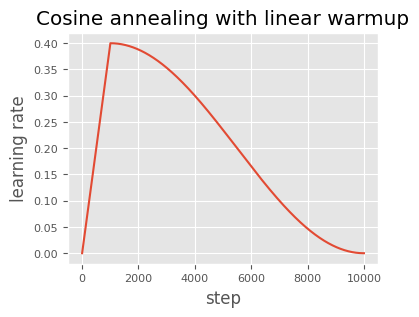

In [2]:
NUM_CLASSES = 100
NUM_EPOCH = 200
NUM_TRAIN = 50000
BATCH_SIZE = 1000
WARMUP_RATIO = 0.1


def create_lr_sched():
    total_step = NUM_EPOCH * (NUM_TRAIN // BATCH_SIZE)
    warmup_step = total_step * WARMUP_RATIO
    return optax.warmup_cosine_decay_schedule(0.0, 0.4, warmup_step, total_step, 0.0)

lr_sched = create_lr_sched()
step = np.arange(NUM_EPOCH * (NUM_TRAIN // BATCH_SIZE))
lr = lr_sched(step)
plt.plot(step, lr)
plt.xlabel('step')
plt.ylabel('learning rate')
plt.title('Cosine annealing with linear warmup')
plt.show()

# Define ResNet

In [3]:
from typing import Any, Callable, Tuple, Sequence

ModuleType = Any

@dataclass
class Block(hk.Module):
    name : str
    conv : ModuleType
    norm : ModuleType
    act : Callable
    filters : int
    stride : int = 1
    
    def __call__(self, x, train):
        y = x
        y = self.norm(name=f'{self.name}_norm_0')(y, train)
        y = self.act(y)
        y = self.conv(output_channels=self.filters, kernel_shape=3, name=f'{self.name}_conv_0')(y)
        y = self.norm(name=f'{self.name}_norm_1')(y, train)
        y = self.act(y)
        y = self.conv(output_channels=self.filters, kernel_shape=3, stride=self.stride, name=f'{self.name}_conv_1')(y)
        
        if x.shape != y.shape:
            x = self.conv(output_channels=self.filters, kernel_shape=1, stride=self.stride, name=f'{self.name}_shorcut')(x)
        
        return x + y
    
@dataclass
class ResNet(hk.Module):
    name : str
    block_cls : ModuleType
    stage_sizes : Sequence[int]
    num_filters : Sequence[int]
    strides : Sequence[int]
    num_classes : int
    act : Callable = jax.nn.relu
    
    def __call__(self, x, train=True):
        conv = partial(
            hk.Conv2D,
            with_bias=False,
        )
        norm = partial(
            hk.BatchNorm,
            create_scale=True,
            create_offset=True,
            decay_rate=0.9,
            eps=1e-5,
        )
        
        x = conv(
            output_channels=64,
            kernel_shape=3,
            stride=1,
            name=f'{self.name}_embedding',
        )(x)
        
        for i, block_size in enumerate(self.stage_sizes):
            for j in range(block_size):
                # only the first block of block_group follows stride
                # other blocks are stride 1.
                stride = (1 if (j > 0) else self.strides[i])
                x = self.block_cls(
                    name=f'block_{i}_{j}',
                    conv=conv,
                    norm=norm,
                    filters=self.num_filters[i],
                    stride=stride,
                    act=self.act
                    )(x, train)
        
        x = norm(name=f'{self.name}_final_norm')(x, train)
        x = self.act(x)
        x = x.mean(axis=(1,2))
        x = hk.Linear(self.num_classes, name=f'{self.name}_head')(x)
        return x

In [4]:
rng = jax.random.PRNGKey(42)
batch = jnp.zeros((1, 32, 32, 3), jnp.float32)
net = partial(
    ResNet,
    name='ResNet_18',
    stage_sizes=[2, 2, 2, 2],
    num_filters=[64, 128, 256, 512],
    strides=[1, 2, 2, 2],
    block_cls=Block,
    num_classes=NUM_CLASSES,
)
net = make_forward_with_state(net)
params, state = net.init(rng, batch, train=True)

# import graphviz
# dot = hk.experimental.to_dot(net.apply)(params, state, rng, batch)
# graphviz.Source(dot)

tx = optax.sgd(learning_rate=create_lr_sched(), momentum=0.9)
trainer = Trainer.create(
    apply_fn=net.apply,
    params=params,
    state=state,
    tx=tx,
)

In [5]:
WD_COEF = 5e-4

def loss_fn(params, trainer, batch, rng):
    # state contains batch statistics
    logit, state = trainer.apply_fn(params, trainer.state, rng, batch['x'], train=True)
    log_prob = jax.nn.log_softmax(logit)
    cross_entropy_loss = - (batch['y'] * log_prob).sum(axis=-1).mean()
    
    wd = (params_to_vec(params)**2).sum()
    
    loss = cross_entropy_loss + WD_COEF * wd
    acc = (jnp.argmax(logit, axis=-1) == jnp.argmax(batch['y'], axis=-1)).astype(int).mean()
    
    return loss, (cross_entropy_loss, wd, acc, state)

In [6]:
def opt_step(trainer, batch, rng):

  grad_fn = jax.grad(loss_fn, has_aux=True)
  grads, (loss, wd, acc, new_state) = grad_fn(
      trainer.params,
      trainer,
      batch,
      rng,
  )

  grad_norm = jnp.sqrt((params_to_vec(grads)**2).sum())
  
  grads = jax.lax.pmean(grads, axis_name='batch')
  new_state = jax.lax.pmean(new_state, axis_name='batch')
  trainer = trainer.apply_gradients(grads=grads, state=new_state)

  log = {
      'loss': loss,
      'wd': wd,
      'acc': acc,
      'grad_norm': grad_norm,
  }
  log = jax.lax.pmean(log, axis_name='batch')

  return log, trainer

In [7]:
import tensorflow as tf
tf.config.experimental.set_visible_devices([], 'GPU')
import tensorflow_datasets as tfds

IMG_MEAN = (0.5, 0.5, 0.5)
IMG_STD = (0.2, 0.2, 0.2)

def load_dataset(batch_dims, train=True, shuffle=True, repeat=True):
    total_batch_size = np.prod(batch_dims)
    
    if train:
        ds = tfds.load(
            f'cifar{NUM_CLASSES}',
            data_dir='../../tensorflow_datasets/',
            split='train',
        )
    else:
        ds = tfds.load(
            f'cifar{NUM_CLASSES}',
            data_dir='../../tensorflow_datasets/',
            split='test',
        )
        
    def preprocess(sample):
        img = tf.cast(sample['image'], tf.float32) / 255.0
        img -= tf.constant(IMG_MEAN, shape=(1,1,3))
        img /= tf.constant(IMG_STD, shape=(1,1,3))
        label = tf.one_hot(sample['label'], NUM_CLASSES)
        return {'x':img, 'y':label}
    
    ds = ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    
    if shuffle:
        ds = ds.shuffle(NUM_TRAIN)
    if repeat:
        ds = ds.repeat()
        
    def aug(sample):
        img = sample['x']
        img = tf.image.random_flip_left_right(img)
        img = tf.pad(img, [[4,4], [4,4], [0,0]], mode='REFLECT')
        img = tf.image.random_crop(img, (32, 32, 3))
        return {'x':img, 'y':sample['y']}
    
    if train:
        ds = ds.map(aug, num_parallel_calls=tf.data.AUTOTUNE)
        
    ds = ds.batch(total_batch_size, drop_remainder=True)
    
    def batch_reshape(batch):
        for k,v in batch.items():
            batch[k] = tf.reshape(v, batch_dims+v.shape[1:])
        return batch
    
    ds = ds.map(batch_reshape, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    
    yield from tfds.as_numpy(ds)

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [8]:
train_dataset = load_dataset((num_devices, BATCH_SIZE//num_devices))
test_dataset = load_dataset((num_devices, BATCH_SIZE//num_devices), False, False, False)
test_dataset = list(test_dataset)

In [9]:
print(f'# of batches for test daaset : {len(test_dataset)}')
shape = test_dataset[0]['x'].shape
print(f'Shape of batch : {shape}')

# of batches for test daaset : 10
Shape of batch : (8, 125, 32, 32, 3)


In [10]:
def compute_acc_batch(trainer, batch):
    
    logit, state = trainer.apply_fn(trainer.params, trainer.state, None, batch['x'], train=False)
    
    acc = (jnp.argmax(logit, axis=-1) == jnp.argmax(batch['y'], axis=-1)).astype(int).mean()
    
    return acc

compute_acc_batch_pmapped = jax.pmap(compute_acc_batch, axis_name='batch')

def compute_acc_dataset(trainer, dataset):
    acc = 0
    for batch in dataset:
        acc_batch = compute_acc_batch_pmapped(trainer, batch)
        acc += np.mean(acc_batch)
    acc /= len(dataset)
    return acc

In [11]:
opt_step_pmapped = jax.pmap(opt_step, axis_name='batch')
trainer_replicated = replicate(trainer)

In [12]:
for epoch in range(1, NUM_EPOCH+1):
    
    pbar = tqdm(range(NUM_TRAIN // BATCH_SIZE))
    for step in pbar:

        batch = next(train_dataset)
        rng, rng_ = jax.random.split(rng)
        log, trainer_replicated = opt_step_pmapped(trainer_replicated, batch, jax.random.split(rng_, num_devices))

        res = [('epoch', epoch)]
        for k, v in log.items():
            res.append((k, f'{np.mean(v):.4f}'))
        res = dict(res)
        pbar.set_postfix(res)
        
    if (epoch % 10) == 0:
        acc_test = compute_acc_dataset(trainer_replicated, test_dataset)
        print(f'Epoch [{epoch}] Test Accuracy : {acc_test:.4f}')

  0%|          | 0/50 [00:00<?, ?it/s]2022-10-11 21:16:28.887530: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:727] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[3,3,64,128]{1,0,2,3}, u8[0]{0}) custom-call(f32[125,32,32,64]{2,1,3,0}, f32[125,32,32,128]{2,1,3,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_01io->b01f, custom_call_target="__cudnn$convBackwardFilter", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2022-10-11 21:16:29.023580: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:727] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[3,3,64,64]{1,0,2,3}, u8[0]{0}) custom-call(f32[125,32,32,64]{2,1,3,0}, f32[125,32,32,64]{2,1,3,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_01io->b01f, custom_call_target="__cudnn$convBackwardFilter", back

Epoch [10] Test Accuracy : 0.4240


100%|██████████| 50/50 [00:05<00:00,  8.72it/s, epoch=20, acc=0.6030, grad_norm=2.7490, loss=1.4570, wd=2490.2832]


Epoch [20] Test Accuracy : 0.4134


100%|██████████| 50/50 [00:05<00:00,  8.75it/s, epoch=30, acc=0.6290, grad_norm=2.9095, loss=1.3030, wd=2429.6394]


Epoch [30] Test Accuracy : 0.4559


100%|██████████| 50/50 [00:05<00:00,  8.77it/s, epoch=40, acc=0.6450, grad_norm=2.8585, loss=1.2507, wd=2392.8025]


Epoch [40] Test Accuracy : 0.4856


100%|██████████| 50/50 [00:05<00:00,  8.75it/s, epoch=50, acc=0.6430, grad_norm=2.9187, loss=1.2640, wd=2622.5569]


Epoch [50] Test Accuracy : 0.5148


100%|██████████| 50/50 [00:05<00:00,  8.69it/s, epoch=60, acc=0.6580, grad_norm=3.1114, loss=1.2061, wd=2450.0938]


Epoch [60] Test Accuracy : 0.4537


100%|██████████| 50/50 [00:05<00:00,  8.76it/s, epoch=70, acc=0.7080, grad_norm=3.1121, loss=1.0697, wd=2426.5999]


Epoch [70] Test Accuracy : 0.5155


100%|██████████| 50/50 [00:05<00:00,  8.77it/s, epoch=80, acc=0.7380, grad_norm=3.4226, loss=0.9250, wd=2418.9163]


Epoch [80] Test Accuracy : 0.5706


100%|██████████| 50/50 [00:05<00:00,  8.67it/s, epoch=90, acc=0.7210, grad_norm=3.5882, loss=0.9355, wd=2386.9795]


Epoch [90] Test Accuracy : 0.5764


100%|██████████| 50/50 [00:05<00:00,  8.75it/s, epoch=100, acc=0.7720, grad_norm=3.7218, loss=0.7769, wd=2330.0759]


Epoch [100] Test Accuracy : 0.5985


100%|██████████| 50/50 [00:05<00:00,  8.68it/s, epoch=110, acc=0.7980, grad_norm=4.0217, loss=0.7225, wd=2254.9587]


Epoch [110] Test Accuracy : 0.5742


100%|██████████| 50/50 [00:05<00:00,  8.84it/s, epoch=120, acc=0.8250, grad_norm=4.4798, loss=0.5940, wd=2150.8623]


Epoch [120] Test Accuracy : 0.5886


100%|██████████| 50/50 [00:05<00:00,  8.70it/s, epoch=130, acc=0.8500, grad_norm=4.7169, loss=0.4888, wd=2000.8348]


Epoch [130] Test Accuracy : 0.6551


100%|██████████| 50/50 [00:05<00:00,  8.72it/s, epoch=140, acc=0.9230, grad_norm=4.3788, loss=0.2748, wd=1788.5948]


Epoch [140] Test Accuracy : 0.6713


100%|██████████| 50/50 [00:05<00:00,  8.72it/s, epoch=150, acc=0.9560, grad_norm=4.1302, loss=0.1558, wd=1491.3397]


Epoch [150] Test Accuracy : 0.6852


100%|██████████| 50/50 [00:05<00:00,  8.69it/s, epoch=160, acc=0.9880, grad_norm=3.3541, loss=0.0641, wd=1155.9940]


Epoch [160] Test Accuracy : 0.7383


100%|██████████| 50/50 [00:05<00:00,  8.77it/s, epoch=170, acc=0.9990, grad_norm=1.2296, loss=0.0203, wd=896.9141]


Epoch [170] Test Accuracy : 0.7764


100%|██████████| 50/50 [00:05<00:00,  8.73it/s, epoch=180, acc=1.0000, grad_norm=0.9177, loss=0.0155, wd=777.6201]


Epoch [180] Test Accuracy : 0.7843


100%|██████████| 50/50 [00:05<00:00,  8.69it/s, epoch=190, acc=0.9990, grad_norm=0.9331, loss=0.0150, wd=737.4936]


Epoch [190] Test Accuracy : 0.7878


100%|██████████| 50/50 [00:05<00:00,  8.73it/s, epoch=200, acc=1.0000, grad_norm=0.7777, loss=0.0138, wd=731.8677]


Epoch [200] Test Accuracy : 0.7882
